
# Simple Outlier Detection Lab 🏠
**Dataset:** Ames Housing Data (`Ames_Housing_Data.csv` in the same folder)

This mini-lab shows a clean, simple way to:
- detect outliers with the IQR rule,
- handle them with three beginner-friendly methods (remove, cap, replace with median),
- save cleaned datasets for later use.

> Tip: Run cells in order. If you don't have the CSV yet, place it beside this notebook.


## 1) Load the data 📊

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make pandas print less in the console
pd.set_option("display.max_columns", 50)

# Try to load the dataset
csv_path = "Ames_Housing_Data.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Couldn't find {csv_path}. Put it next to this notebook.")

print(f"Rows: {len(df)}, Columns: {df.shape[1]}")
df.head(10)


Rows: 2930, Columns: 81


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,...,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,...,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,...,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,...,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,...,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001,Gable,CompShg,CemntBd,CmentBd,...,0,NaN,Attchd,2001.0,Fin,2.0,582.0,TA,TA,Y,0,0,170,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,...,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,...,1,TA,Attchd,1995.0,RFn,2.0,608.0,TA,TA,Y,237,152,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,1999.0,Fin,2.0,442.0,TA,TA,Y,140,60,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


## 2) Separate numeric vs text columns 🔢

In [2]:

num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = df.select_dtypes(include="object").columns.tolist()

print(f"Numeric columns: {len(num_cols)} | Text columns: {len(cat_cols)}")
print("Example numeric:", num_cols[:5])
print("Example text:", cat_cols[:5])


Numeric columns: 38 | Text columns: 43
Example numeric: ['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual']
Example text: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour']



## 3) IQR outlier rule 🎯

**IQR rule:** values below `Q1 - 1.5*IQR` or above `Q3 + 1.5*IQR` are flagged as outliers.


In [3]:

def iqr_bounds(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

def is_outlier(s: pd.Series, k: float = 1.5):
    s = s.dropna()
    low, up = iqr_bounds(s, k)
    return (s < low) | (s > up), low, up


## 4) Check outliers in one column (SalePrice) 🔍

In [4]:

target_col = "SalePrice"
if target_col not in df.columns:
    raise KeyError(f"'{target_col}' not found in columns: {list(df.columns)[:10]} ...")

flags, low, up = is_outlier(df[target_col])
print(f"Normal {target_col} range: {low:,.0f} to {up:,.0f}")
print(f"Outliers found: {flags.sum()} ({flags.mean()*100:.1f}% of rows)")
df.loc[flags.index[flags].tolist(), target_col].head(5)


Normal SalePrice range: 3,500 to 339,500
Outliers found: 137 (4.7% of rows)


15    538000
17    394432
36    376162
38    395192
44    611657
Name: SalePrice, dtype: int64

## 5) Visualize outliers with a box plot 📈

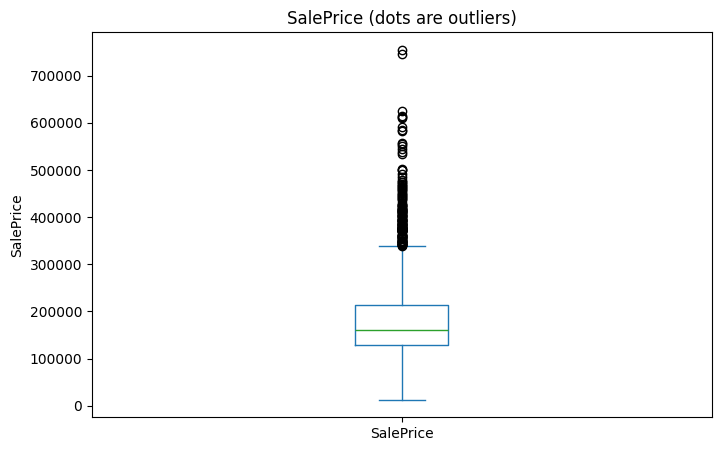

In [5]:

plt.figure(figsize=(8,5))
df[target_col].plot(kind="box")
plt.title(f"{target_col} (dots are outliers)")
plt.ylabel(target_col)
plt.show()


## 6) Scan all numeric columns for outliers 🔄

In [6]:

summary = []
n = len(df)
for col in num_cols:
    s = df[col].dropna()
    if s.empty:
        continue
    mask, _, _ = is_outlier(s)
    summary.append({"Column": col, "Outliers": int(mask.sum()), "Percent": f"{(mask.sum()/n)*100:.1f}%"})

outlier_df = pd.DataFrame(summary).sort_values("Outliers", ascending=False)
print("Top columns with outliers:")
outlier_df.head(10)


Top columns with outliers:


,Column,Outliers,Percent
30,Enclosed Porch,459,15.7%
10,BsmtFin SF 2,351,12.0%
32,Screen Porch,256,8.7%
5,Overall Cond,252,8.6%
1,MS SubClass,208,7.1%
8,Mas Vnr Area,200,6.8%
2,Lot Frontage,187,6.4%
18,Bsmt Half Bath,175,6.0%
29,Open Porch SF,159,5.4%
37,SalePrice,137,4.7%


## 7) Handle outliers: remove, cap, or median 🛠️

In [7]:

def handle_outliers(df_in: pd.DataFrame, method: str = "cap", k: float = 1.5):
    df_clean = df_in.copy()
    for col in df_clean.select_dtypes(include="number").columns:
        s = df_clean[col]
        if s.notna().sum() == 0:
            continue
        low, up = iqr_bounds(s.dropna(), k)
        if method == "remove":
            mask = (s < low) | (s > up)
            df_clean = df_clean.loc[~mask]
        elif method == "median":
            mask = (s < low) | (s > up)
            df_clean.loc[mask, col] = s.median()
        else:  # "cap"
            df_clean[col] = s.clip(lower=low, upper=up)
    return df_clean

df_removed = handle_outliers(df, method="remove")
df_capped  = handle_outliers(df, method="cap")
df_median  = handle_outliers(df, method="median")

print(f"Original rows: {len(df)} | After remove: {len(df_removed)} | Capped: {len(df_capped)} | Median: {len(df_median)}")


Original rows: 2930 | After remove: 1062 | Capped: 2930 | Median: 2930


C:\Users\oishi\AppData\Local\Temp\ipykernel_9556\1826581089.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9436.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[mask, col] = s.median()


## 8) Compare effects on SalePrice 📊

In [8]:

def price_summary(frame, col=target_col):
    return {
        "mean": frame[col].mean(),
        "min": frame[col].min(),
        "max": frame[col].max(),
    }

original = price_summary(df)
removed  = price_summary(df_removed)
capped   = price_summary(df_capped)
medianed = price_summary(df_median)

print("Average SalePrice:")
print(f"  Original : {original['mean']:,.0f}")
print(f"  Removed  : {removed['mean']:,.0f}")
print(f"  Capped   : {capped['mean']:,.0f}")
print(f"  Median   : {medianed['mean']:,.0f}")

print("\nPrice range:")
print(f"  Original : {original['min']:,.0f} - {original['max']:,.0f}")
print(f"  Removed  : {removed['min']:,.0f} - {removed['max']:,.0f}")
print(f"  Capped   : {capped['min']:,.0f} - {capped['max']:,.0f}")
print(f"  Median   : {medianed['min']:,.0f} - {medianed['max']:,.0f}")


Average SalePrice:
  Original : 180,796
  Removed  : 182,564
  Capped   : 177,082
  Median   : 168,689

Price range:
  Original : 12,789 - 755,000
  Removed  : 60,000 - 335,000
  Capped   : 12,789 - 339,500
  Median   : 12,789 - 338,931


In [10]:

def clean_outliers(df_in: pd.DataFrame, method: str = "cap", k: float = 1.5):
    df_clean = df_in.copy()
    for col in df_clean.select_dtypes(include="number").columns:
        s = df_clean[col]
        if s.notna().sum() == 0:
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, up = q1 - k * iqr, q3 + k * iqr
        if method == "cap":
            df_clean[col] = s.clip(lower=low, upper=up)
        elif method == "median":
            mask = (s < low) | (s > up)
            df_clean.loc[mask, col] = s.median()
        elif method == "remove":
            mask = (s < low) | (s > up)
            df_clean = df_clean.loc[~mask]
    return df_clean

# Example:

df_cleaned = clean_outliers(df, method="cap", k=1.5)

df_cleaned


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,...,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,113.0,17727.75,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5.0,1960.0,1960,Hip,CompShg,BrkFace,Plywood,...,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622.00,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6.0,1961.0,1961,Gable,CompShg,VinylSd,VinylSd,...,0.0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267.00,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6.0,1958.0,1958,Hip,CompShg,Wd Sdng,Wd Sdng,...,0.0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,0,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160.00,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5.0,1968.0,1968,Hip,CompShg,BrkFace,BrkFace,...,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830.00,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5.0,1997.0,1998,Gable,CompShg,VinylSd,VinylSd,...,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,923275080,80,RL,37.0,7937.00,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6.0,1984.0,1984,Gable,CompShg,HdBoard,HdBoard,...,0.0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,923276100,20,RL,NaN,8885.00,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5.0,1983.0,1983,Gable,CompShg,HdBoard,HdBoard,...,0.0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,923400125,85,RL,62.0,10441.00,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5.0,1992.0,1992,Gable,CompShg,HdBoard,Wd Shng,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,0,7,2006,WD,Normal,132000
2928,924100070,20,RL,77.0,10010.00,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5.0,1974.0,1975,Gable,CompShg,HdBoard,HdBoard,...,1.0,TA,Attchd,1975.0,RFn,2.0,418.0,TA,TA,Y,240,38,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
